In [1]:
import sys

import pandas as pd

sys.path.append("../../src")
from main.transporter_dataset import create_dataset
from main.eval import full_test
from main.compositions import calculate_aac, calculate_paac
from main.pssm import calculate_pssms_notebook
import matplotlib.pyplot as plt
import seaborn as sns

LOG_FILE = "../../logs/athaliana_amino_sugar_potassium.log"


In [2]:
sodium = ["Q2UVJ5", "O04034", "Q9FKP1", "Q9LJI2", "Q9SYG9", "Q84TI7"]
gdu = ["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"]
df_all = create_dataset(
    keywords_substrate_filter=[
        "Amino-acid transport",
        "Electron transport",
        "Sugar transport",
        "Potassium transport",
    ],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    outliers=gdu + sodium,
    verbose=True,
    tax_ids_filter=[3702],
    output_log=LOG_FILE,
    sequence_clustering=70,
)


cd-hit: clustered 297 sequences into 223 clusters at threshold 70


# Feature generation

In [3]:
df_aac = calculate_aac(df_all.sequence)
df_paac = calculate_paac(df_all.sequence)
df_pssm = calculate_pssms_notebook(df_all.sequence)
df_combined = pd.concat([df_aac, df_paac, df_pssm], axis=1)
labels = df_all.keywords_transport
labels.value_counts()

Sugar transport         84
Electron transport      56
Potassium transport     50
Amino-acid transport    33
Name: keywords_transport, dtype: int64

# Function

In [4]:
def test_case(df_features, labels: pd.Series, test_name: str, **kwargs):
    for dim_reduction in [None, "pca", "kbest"]:
        print("#" * 60)
        print("Feature reduction: ", dim_reduction)
        print("#" * 60)
        df_scores, df_params = full_test(
            df_features, labels, kernel="rbf", dim_reduction=dim_reduction, **kwargs
        )
        df_scores.label = df_scores.label.map(lambda x: x.replace(" transport", ""))

        display(df_params)
        df_scores_piv = df_scores.groupby(["label", "dataset"]).mean().unstack(1)
        df_scores_piv.loc["mean"] = df_scores_piv.mean()
        display(df_scores_piv.round(3))

        g = sns.barplot(data=df_scores, y="F1 score", x="label", hue="dataset")
        g.set_ylim((0, 1))
        g.set_xlabel("")
        plt.savefig(f"{test_name}_{dim_reduction}_barplot.png")
        plt.show()

        g = sns.boxplot(data=df_scores, y="F1 score", x="label", hue="dataset")
        g.set_xlabel("")
        g.set_ylim((0, 1))
        plt.savefig(f"{test_name}_{dim_reduction}_boxplot.png")
        plt.show()


# Eval AAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,1,10,100,10,10,10,10,1,1
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.697  0.794
Electron      0.890  0.893
Potassium     0.959  0.964
Sugar         0.863  0.887
mean          0.852  0.885

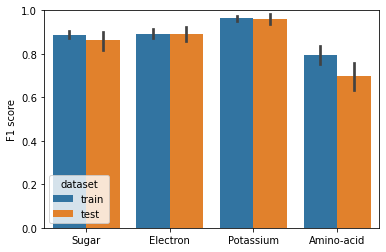

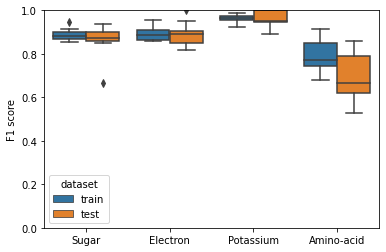

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.91,0.99,0.94,0.96,0.96,0.99,0.99,0.85,0.96,0.93
svc__C,1,1,10,10,10,10,1,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.673  0.770
Electron      0.891  0.875
Potassium     0.959  0.945
Sugar         0.844  0.863
mean          0.842  0.863

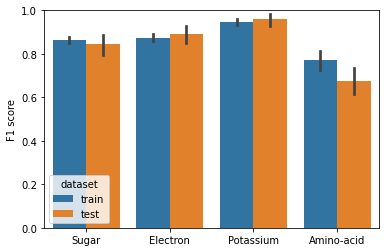

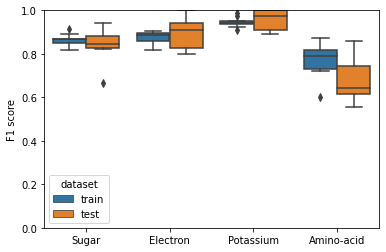

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,18,19,18,18,19,18,19,17,13,19
svc__C,10,1,1,10,10,1,10,1,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.675  0.815
Electron      0.862  0.892
Potassium     0.955  0.965
Sugar         0.875  0.896
mean          0.842  0.892

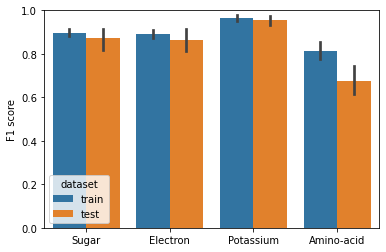

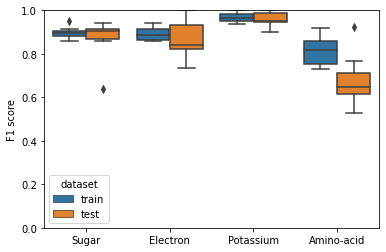

In [5]:
test_case(
    df_aac,
    labels,
    test_name="AAC",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    class_weight=["balanced"],
    C=[1, 10, 100],
)

# Eval PAAC

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
svc__C,10,10,1,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.701  0.750
Electron      0.892  0.867
Potassium     0.951  0.918
Sugar         0.883  0.885
mean          0.857  0.855

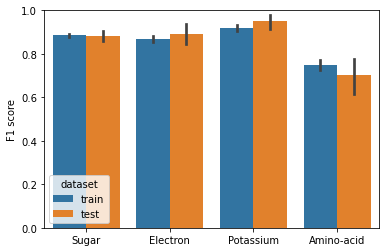

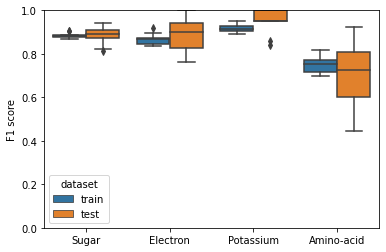

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.99,0.99,0.99,0.99,0.99,0.8,0.99,0.99,0.99,0.99
svc__C,10,1,1,10,10,10,10,10,1,1
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.647  0.641
Electron      0.542  0.586
Potassium     0.852  0.784
Sugar         0.790  0.770
mean          0.708  0.695

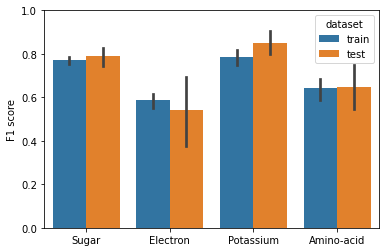

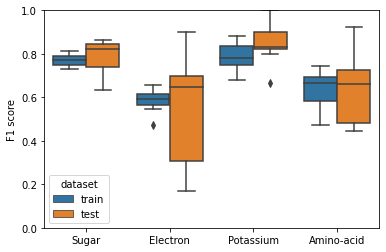

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
selectkbest__k,218,260,214,324,267,232,192,348,296,284
svc__C,10,10,10,10,10,10,10,10,1,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.734  0.805
Electron      0.884  0.886
Potassium     0.955  0.925
Sugar         0.884  0.904
mean          0.864  0.880

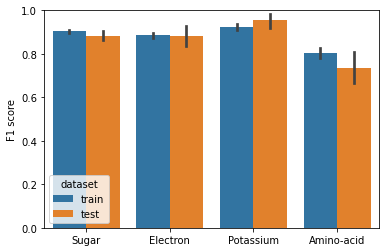

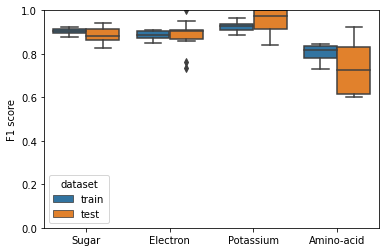

In [6]:
test_case(df_paac, labels, test_name="PAAC",decision_function_shape=["ovo"], gamma=["scale"], C=[1,10,100], class_weight=["balanced"])

# PSSM

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
svc__C,10,10,10,1,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.936  0.910
Electron      0.987  0.979
Potassium     0.995  0.982
Sugar         0.977  0.959
mean          0.974  0.957

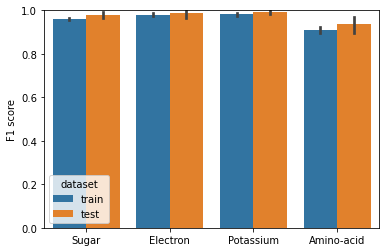

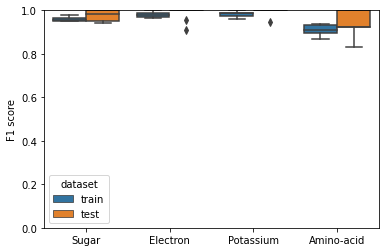

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.94,0.93,0.95,0.94,0.95,0.94,0.96,0.95,0.93,0.89
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.941  0.960
Electron      0.980  0.975
Potassium     0.995  0.986
Sugar         0.963  0.974
mean          0.970  0.974

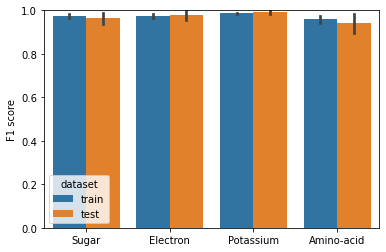

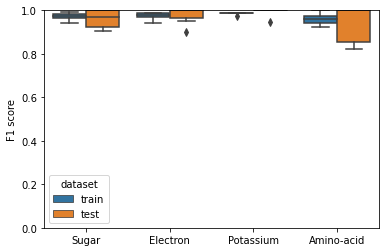

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
selectkbest__k,1491,1281,521,1521,1451,541,1311,1491,1551,1441
svc__C,10,10,10,1,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.944  0.933
Electron      0.987  0.980
Potassium     0.995  0.983
Sugar         0.980  0.965
mean          0.976  0.966

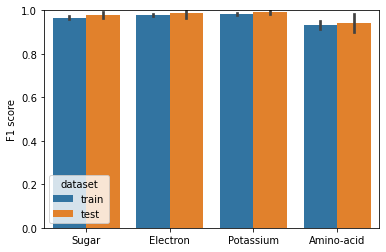

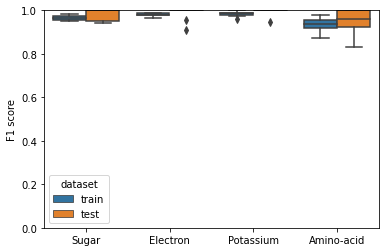

In [7]:
test_case(
    df_pssm,
    labels,
    test_name="PSSM",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    C=[1, 10, 100],
    class_weight=["balanced"],
    feature_filter="pssm",
    select_k_steps=10,
)

# Combined

############################################################
Feature reduction:  None
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.936  0.883
Electron      0.986  0.979
Potassium     1.000  0.987
Sugar         0.975  0.948
mean          0.974  0.949

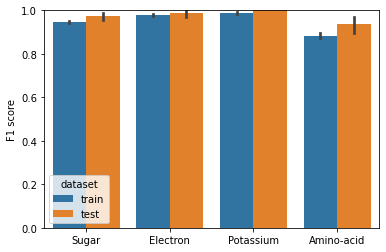

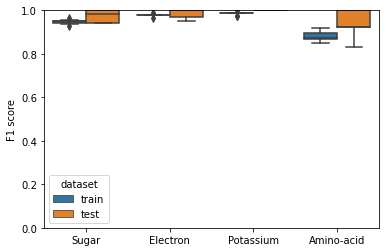

############################################################
Feature reduction:  pca
############################################################


,0,1,2,3,4,5,6,7,8,9
pca__n_components,0.81,0.83,0.8,0.8,0.82,0.81,0.8,0.86,0.8,0.81
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
svc__C,1,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.913  0.911
Electron      0.945  0.942
Potassium     0.990  0.985
Sugar         0.952  0.945
mean          0.950  0.946

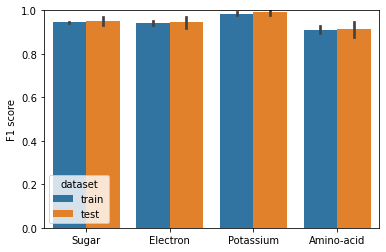

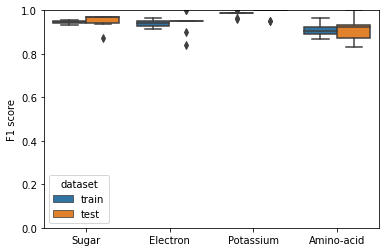

############################################################
Feature reduction:  kbest
############################################################


,0,1,2,3,4,5,6,7,8,9
pssmselector__iterations,1,1,1,1,1,1,1,1,1,1
pssmselector__uniref_threshold,50,50,50,50,50,50,50,50,50,50
selectkbest__k,1291,1291,251,1581,811,681,1481,351,1371,1421
svc__C,10,10,10,10,10,10,10,10,10,10
svc__class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
svc__decision_function_shape,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo,ovo
svc__gamma,scale,scale,scale,scale,scale,scale,scale,scale,scale,scale


F1 score       
dataset        test  train
label                     
Amino-acid    0.939  0.933
Electron      0.978  0.978
Potassium     0.989  0.990
Sugar         0.974  0.969
mean          0.970  0.967

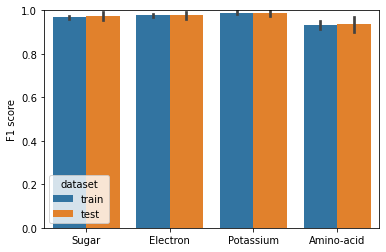

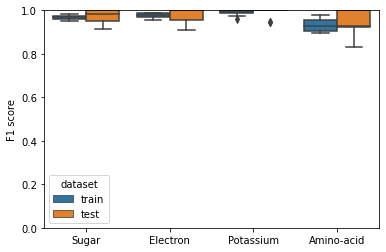

In [8]:
test_case(
    pd.concat([df_aac, df_paac, df_pssm], axis=1),
    labels,
    test_name="Combined",
    decision_function_shape=["ovo"],
    gamma=["scale"],
    C=[1, 10, 100],
    class_weight=["balanced"],
    feature_filter="pssm",
    select_k_steps=10,
)
